<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>CNN
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Modellerklärung

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed euismod, nisl quis tincidunt aliquam, nunc nisl ultricies nunc, sit amet ultricies nisl ante nec leo. Donec vitae ex euismod, tincidunt nisl quis, gravida nisl. Sed vitae quam vitae nisl tincidunt lacinia. Nullam et semper nisl, sed rutrum ipsum. Donec ac odio nec dolor ultricies aliquam. Sed id nisl at nisi ultricies ultrices. Curabitur sed neque eget tortor vulputate imperdiet. Sed vitae dui nec justo aliquam ultrices. Sed id nunc euismod, ultricies velit nec, aliquam urna. Sed eget semper eros. Sed et nisl at magna ultricies lobortis. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Sed vel massa auctor, aliquet libero et, aliquet odio. Nulla facilisi. Sed sit amet dolor vel diam tincidunt aliquet. Donec sed tortor eget sapien gravida aliquet.

## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [23]:
# All Imports
import sys
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from   tensorflow import keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import keras.backend as K

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")
print(f"Tensorflow Version: {tf.__version__}")

# Warnings Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (24, 12)

Python Version: 3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]
PyTorch Version: 1.12.1+cu116
Numpy Version: 1.23.5
Pandas Version: 1.5.0
Matplotlib Version: 3.6.2
Sklearn Version: 1.1.2
Seaborn Version: 0.12.0
Tensorflow Version: 2.11.0


## Einlesen des Verarbeiteten Datensatzes

In [4]:
train = pd.read_csv("./data/processed/train.csv")
val = pd.read_csv("./data/processed/val.csv")
test = pd.read_csv("./data/raw/test.csv")

## Pre-Processing

In [5]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train.text)

train_tokens = tokenizer.texts_to_sequences(train.text)
val_tokens = tokenizer.texts_to_sequences(val.text)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

categories = 1 

print(f"Maximal number of words of sentences {max([len(lst) for lst in train_tokens])}")

maxlen = 40

train_tokens = pad_sequences(train_tokens, padding='post', maxlen=maxlen)
val_tokens = pad_sequences(val_tokens, padding='post', maxlen=maxlen)

Maximal number of words of sentences 31


## Helper Functions

Hier werden Funktionen definiert, die bei beiden Modellen verwendet werden.

In [28]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def plot_confusion_matrix(model,val_tokens=val_tokens):
    y_prediction = model.predict(val_tokens,verbose=False) > 0.5
    disp= ConfusionMatrixDisplay(confusion_matrix(val.target, y_prediction),display_labels = ["no disaster","disaster"])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues,ax=ax)
    plt.show()


def plot_f1_score_loss(history):
    #  "f1-score"
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 4))
    ax1.plot(history.history['get_f1'])
    ax1.plot(history.history['val_get_f1'])
    ax1.set_title('model f1-score')
    ax1.set_ylabel('f1.score')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    # "Loss"
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [7]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 50, input_length=40))
model.add(keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(100, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(20, activation=tf.nn.relu))
model.add(keras.layers.Dense( categories, activation=tf.nn.sigmoid))
#model.add(keras.layers.Dense(4, activation='sigmoid'))
print(model.summary())

model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
history = model.fit(train_tokens, train.target, epochs=20, batch_size=512, validation_data=(val_tokens, val.target), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            978200    
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           32128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 100)               230500    
                                                        

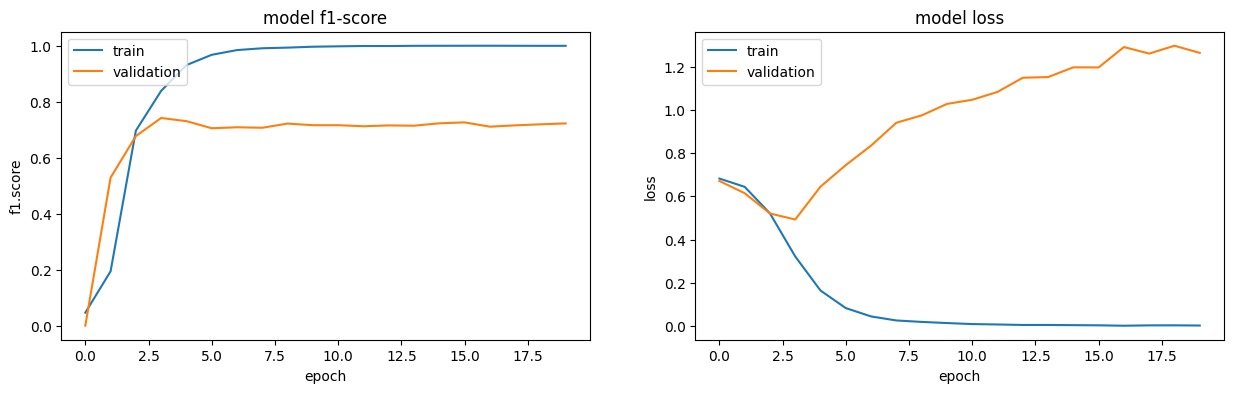

In [22]:
plot_f1_score_loss(history)

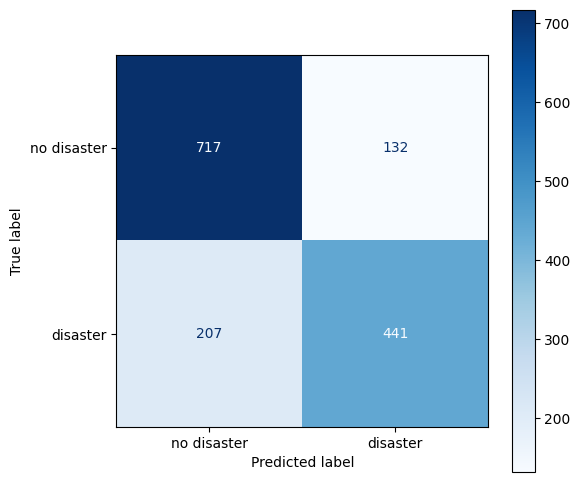

In [29]:
plot_confusion_matrix(model)

## Klassifikationsmodell

### Auswertung des Modells

## Evaluation
In der Evaluation beschreiben wir, welche Metrik verwendet wurde, wieso die Metrik für den Anwendungsfall passt und diskutieren die Ergebnisse der Experimente und einige Vorhersagen auf einzelnen Testsamples.

## Erkenntnisse

## Fazit